In [1]:
# !pip install alibi-detect
# !pip install alibi-detect[tensorflow]

In [2]:
%env TF_CPP_MIN_LOG_LEVEL=2

import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# tf.keras.backend.set_floatx('float16')
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.models.tensorflow import elbo
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

env: TF_CPP_MIN_LOG_LEVEL=2
2.4.1


# debug note
https://github.com/huggingface/transformers/issues/18549
pip uninstall tokenizers
pip install transformers

In [3]:
# !conda install -c conda-forge imgviz -y
# !pip install empatches

In [4]:
from empatches import EMPatches
import imgviz # just for plotting


## Patching function

In [5]:
# sizeBins = [128, 256, 512]
sizeBins = [64, 128, 256]

def resize_patch(path='/kaggle/input/anom-toy-sds-odv2v2/bad/21_jpg.rf.16764428da35866c0b12e3fea096447b.jpg', patchsize=64):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(img.shape)
    height, width, channels = img.shape
    # height = 525
    size = np.digitize(np.min(img.shape[0:2]), bins=sizeBins, right=True) -1
    # print("Bin cat:",size)
    img = cv2.resize(img,(sizeBins[size],sizeBins[size]))

#     img = cv2.resize(img,(301,201))
    # print(img.shape)
    # plt.figure()
    # plt.imshow(img)
    # load module
    emp = EMPatches()
    img_patches, indices = emp.extract_patches(img, patchsize=patchsize, overlap=0.000)
    # print(len(img_patches))
    # print(img_patches[0].shape)
    # img_patches[-1] = np.rot90(img_patches[0])

#     img_patches[0] = img_patches[0]**2
    # displaying 1st 10 image patches
    # tiled= imgviz.tile(list(map(np.uint8, img_patches[0:])),border=(255,0,0))
    # plt.figure()
    # plt.imshow(tiled)

#     merged_img = emp.merge_patches(img_patches, indices, mode='avg') # or
#     # display
#     plt.figure()
#     plt.imshow(merged_img.astype(np.uint8))
    
    return img_patches, indices
    
img_patches, indices = resize_patch("datasets/good/473_jpg.rf.f4bff0992b3f3744f67ad7d2e8cc2541.jpg")
type(img_patches)

list

## Data loader

In [6]:
# !pip install natsort

In [7]:
##########################################################################
#Load data. We only need good data and anything NOT good is an outlier. 
from natsort import natsorted

image_directory = './datasets/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  


def basicDataset(path="",size=64, limit=10):
    dataset = [] 
    images = natsorted(os.listdir(path))
    for i, image_name in zip(range(limit), images):
        # print (path+image_name)
        if (image_name.split('.')[-1] == 'jpg'):
            img_patches, indices = resize_patch(path+image_name, size)
            dataset.extend(img_patches)
    
    return np.array(dataset)

In [8]:
# train = basicDataset(path=(image_directory + 'good/'), size=SIZE, limit=999999999999999999).astype('float32') / 255.
# print(train.shape)

In [9]:
bad_dataset = basicDataset(path=(image_directory + 'bad/'), size=SIZE, limit=200000).astype('float32') / 255.
print(bad_dataset.shape)

(2000, 64, 64, 3)


In [10]:
mixed_dataset = basicDataset(path=(image_directory + 'mixed/'), size=SIZE, limit=9999999999).astype('float32') / 255.
print(mixed_dataset.shape)

(4400, 64, 64, 3)


## export trained model

In [11]:
# save the trained outlier detector
#As mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7
# from alibi_detect.utils import save_detector, load_detector  #If this does not work, try the next line
# # from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work. 
from alibi_detect.saving import save_detector
# filepath = './14-5-50epochtoy/'
# save_detector(od, filepath)

## import trained model

In [12]:
from alibi_detect.saving import load_detector

filepath = 'model_backup/14-5-100epochtoy/'
od = load_detector(filepath)

/home/skb/miniconda3/envs/colab/lib/python3.7/site-packages/alibi_detect/saving/_tensorflow/loading.py:221: UserWarning: Trying to load detector from version 0.11.2 when using version 0.11.1. This may lead to breaking code or invalid results.
  warnings.warn(f'Trying to load detector from version {meta_dict["version"]} when using version '


## Test our model on a outlier image

In [13]:
# od.infer_threshold(mixed_dataset, outlier_type='feature', threshold_perc=80.0, batch_size =2)
# print("Current threshold value is: ", od.threshold)

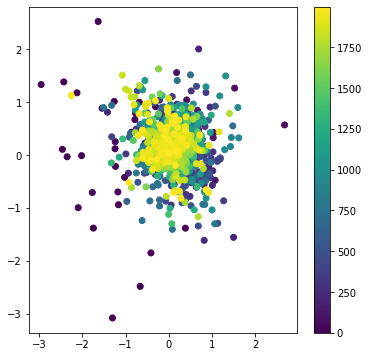

TensorShape([2000, 1024])

In [134]:
# https://github.com/SeldonIO/alibi-detect/blob/21ca540f5b0ff8f2ee312e7a30ace0d27c238435/alibi_detect/models/tensorflow/autoencoder.py#LL118C9-L118C47
# test_bad_image_code = od.vae.encoder (test_bad_image)  #z_mean, z_log_var, z = self.encoder(x), z is a sampling from the distribution z= z_mean + tf.exp(0.5 * z_log_var) * epsilon
# test_bad_image_code[2].shape

# display a 2D plot of the latent space
dataset_batch = bad_dataset
_, _, codes = od.vae.encoder (dataset_batch)
plt.figure(figsize=(6, 6))
plt.scatter(codes[:, 0], codes[:, 1], c=list(range(len(dataset_batch))))
plt.colorbar()
plt.show()
codes.shape

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


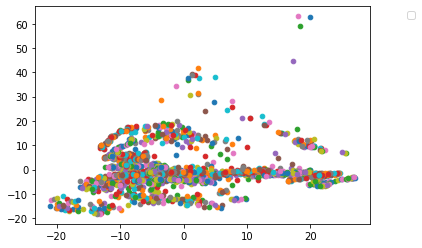

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.245214
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.136208
[t-SNE] KL divergence after 1000 iterations: 0.993502


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


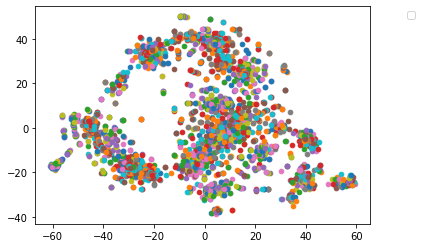

In [135]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
codes_pca = pca.fit_transform(X=codes)
# print((codes_pca.shape))
# labels=list(range(16))
for i in range(len(dataset_batch)):
    
    plt.scatter(x=codes_pca[i][0], y=codes_pca[i][1], s=21.5)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

from sklearn.manifold import TSNE
codes_tsne = TSNE(n_components=2, learning_rate='auto', init='random',verbose=1).fit_transform(codes)
for i in range(len(dataset_batch)):
    
    plt.scatter(x=codes_tsne[i][0], y=codes_tsne[i][1], s=21.5)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

input to model shape:  (1, 64, 64, 3)
recon shape:  (1, 64, 64, 3)
Is this image an outlier (0 for NO and 1 for YES)? 1
(1, 64, 64, 3)
(64, 64, 3)


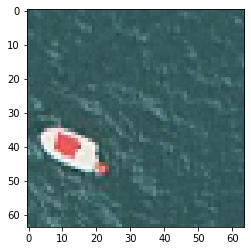

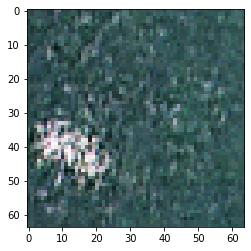

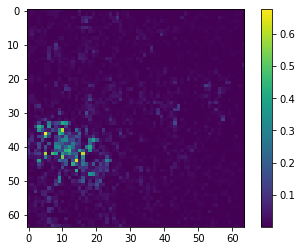

In [136]:
img_num = 92
img_num = 32
# print(bad_dataset.shape)
test_bad_image = bad_dataset[58].reshape(1, SIZE, SIZE, 3)

print("input to model shape: ", test_bad_image.shape)


test_bad_image_recon = od.vae(test_bad_image)
print("recon shape: ", test_bad_image_recon.shape)

test_bad_image_recon = test_bad_image_recon.numpy()


# Y = od.predict(test_bad_image, outlier_perc=91.0) #Returns a dictionary of data and metadata
# print("Current threshold value is: ", od.threshold)
Y = od.predict(test_bad_image)


print("Is this image an outlier (0 for NO and 1 for YES)?", Y['data']['is_outlier'][0])
Y_masks = Y['data']['feature_score']
mask0 = Y_masks[0]

print(Y_masks.shape)
print(mask0.shape)


plt.imshow(test_bad_image[0])
plt.show()

plt.imshow(test_bad_image_recon[0])
plt.show()

plt.imshow(mask0.max(axis=2))
plt.colorbar()
plt.show()

#You can also manually define the threshold based on your specific use case. 
# od.threshold = 0.002
# print("Current threshld value is: ", od.threshold)

# test on batch (currently single image patched into batches)

## Run prediction and plot results

In [137]:
import skimage.measure

def plot_results_on_single_image(path="", savepath=None):
    img_patches, indices = resize_patch(path)

    emp = EMPatches()

    X_p = np.array(img_patches).astype('float32') / 255.

    Y_p = od.predict(X_p,
                        outlier_type='instance',    # use 'feature' or 'instance' level
                        return_feature_score=True,  # scores used to determine outliers
                        return_instance_score=True)

    Y_masks = Y_p['data']['feature_score']

    Y_masks_list = [*Y_masks]

    X = np.array(emp.merge_patches(img_patches, indices, mode='avg')).astype('float32') / 255.


    pred_heatmap_merged = emp.merge_patches(Y_masks_list, indices, mode='avg')

    Y['data']['feature_score'] = pred_heatmap_merged[np.newaxis]



    X_p_recon = od.vae(X_p).numpy()

    X_recon = emp.merge_patches([*X_p_recon], indices, mode='avg')



    plt.figure()
    # plt.colorbar()
    plot_feature_outlier_image(Y,
                            X[np.newaxis],
                            X_recon=X_recon[np.newaxis],
                            instance_ids=[0],  # pass a list with indices of instances to display
                            max_instances=16,  # max nb of instances to display
                            outliers_only=False)  # only show outlier predictions

    # plt.colorbar()
    plt.show()
    ##############################

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_title('Heatmap')
    pcm = ax1.imshow(pred_heatmap_merged.max(axis=2))
    fig.colorbar(pcm, ax=ax1, fraction=0.046, pad=0.04)
    pred_heatmap_merged_maxpool = skimage.measure.block_reduce(pred_heatmap_merged, (64,64,3), np.max)
    
    ax2.set_title('Heatmap:Maxpooled')
    pcm2 = ax2.imshow(pred_heatmap_merged_maxpool)
    fig.colorbar(pcm2, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()
    return pred_heatmap_merged

<Figure size 432x288 with 0 Axes>

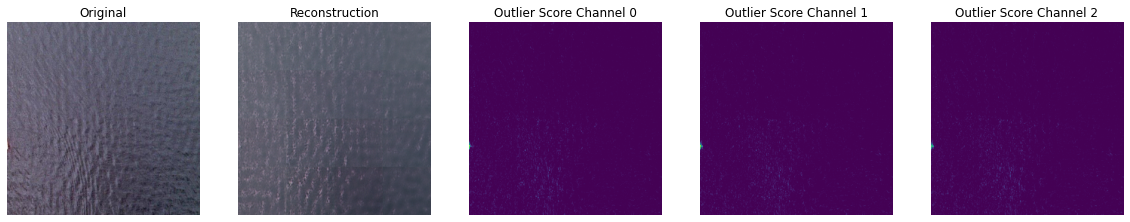

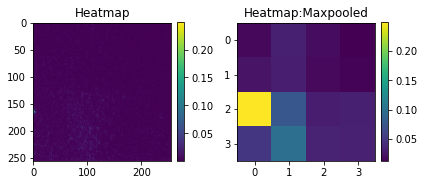

<Figure size 432x288 with 0 Axes>

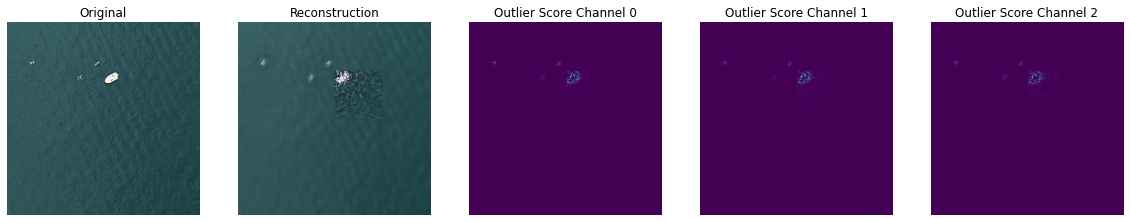

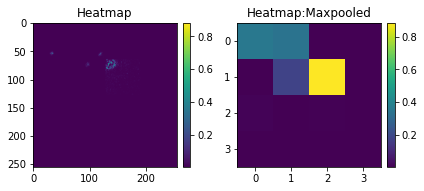

<Figure size 432x288 with 0 Axes>

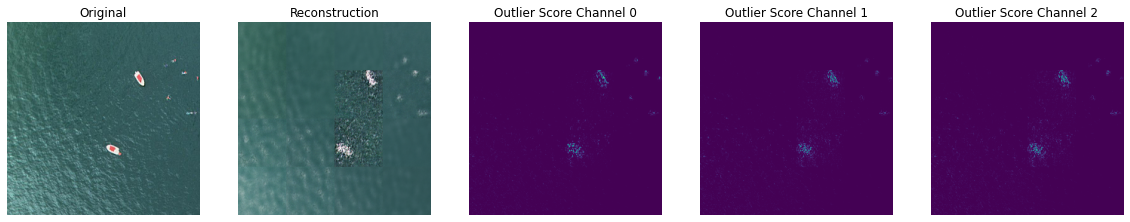

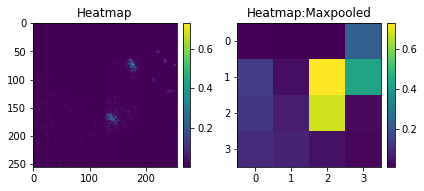

<Figure size 432x288 with 0 Axes>

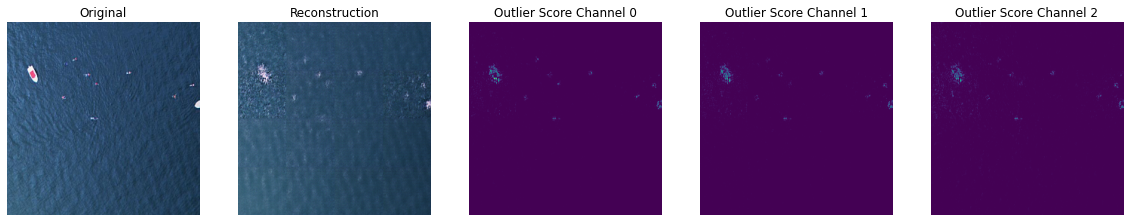

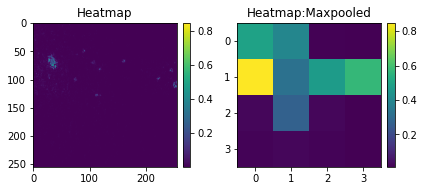

<Figure size 432x288 with 0 Axes>

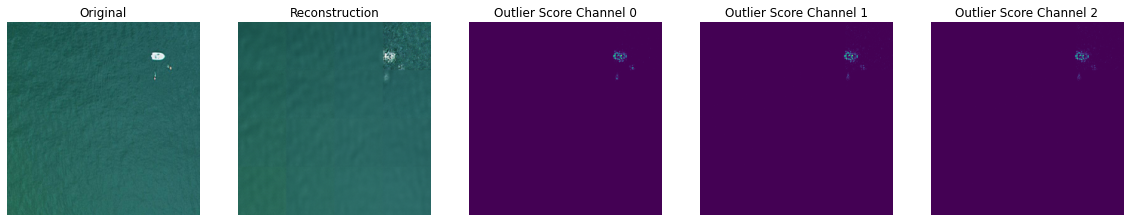

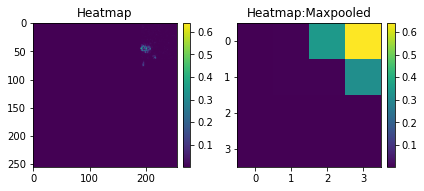

<Figure size 432x288 with 0 Axes>

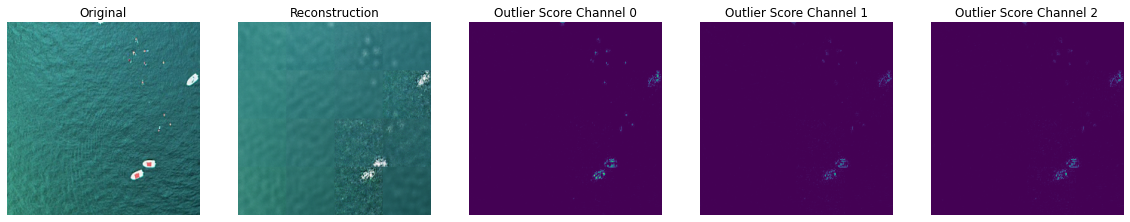

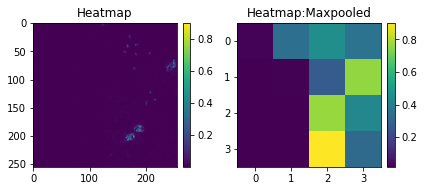

<Figure size 432x288 with 0 Axes>

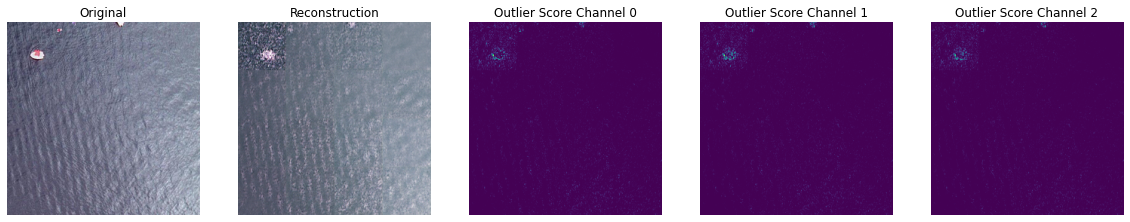

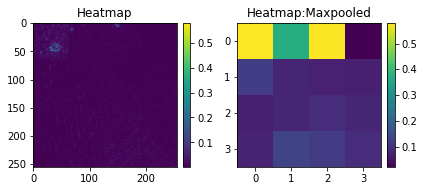

<Figure size 432x288 with 0 Axes>

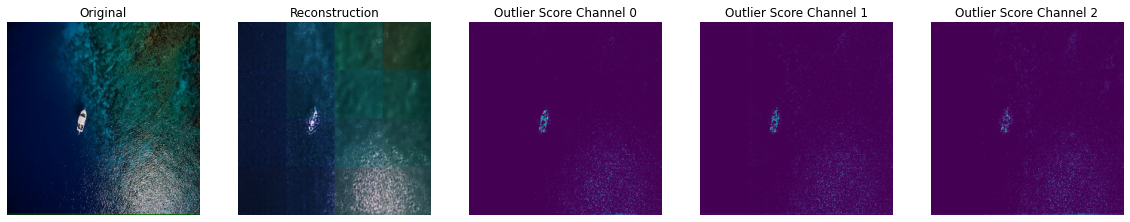

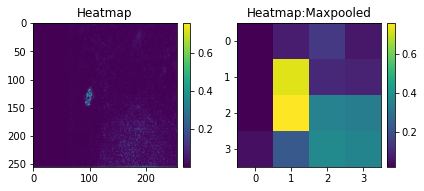

<Figure size 432x288 with 0 Axes>

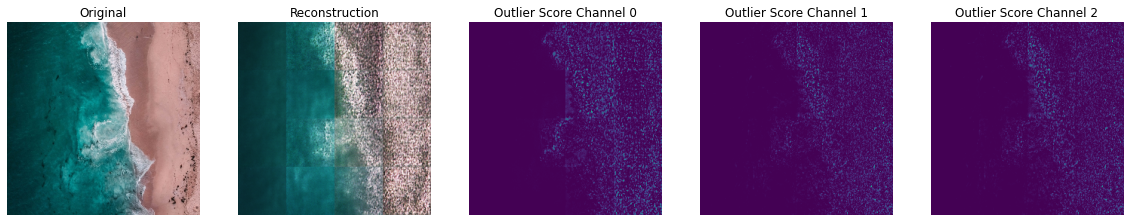

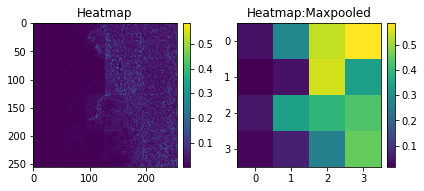

In [138]:
image_list =[]
image_list.append("datasets/mixed/53_jpg.rf.4976870a5e5af15e47206832ade51ed6.jpg")
image_list.append("datasets/bad/2_jpg.rf.608f62cb2efc758f0131436d14648245.jpg")

image_list.append("datasets/bad/2_jpg.rf.b3825c825aaf701aec50ffd14efe4869.jpg")

image_list.append("datasets/bad/5_jpg.rf.efd13187101f89b1879fde68a8cd51d9.jpg")
image_list.append("datasets/bad/12_jpg.rf.3e89e71970211bfc29395fc2a8524c99.jpg")
image_list.append("datasets/mixed/47_jpg.rf.e9ddd312d9bce1895776d1c2a1c19f94.jpg")
image_list.append("datasets/bad/8_jpg.rf.b9f95418c204e14db64bc06bcf057d94.jpg")
image_list.append("aerial-shot-boat-beautiful-blue-ocean-bonaire-caribbean_181624-6680.jpg")
image_list.append("aerial-shot-shoreline.jpg")
results = []
for path in image_list:
    results.append(plot_results_on_single_image(path=path))

In [139]:

import numpy as np
import skimage.measure

a = np.array([
      [  20,  200,   -5,   23],
      [ -13,  134,  119,  100],
      [ 120,   32,   49,   25],
      [-120,   12,    9,   23]
])
print(a.shape)
skimage.measure.block_reduce(a, (2,2), np.max)

(4, 4)


array([[200, 119],
       [120,  49]])

(256, 256, 3)
(37, 37, 1)
(37, 37, 1)
(37, 37, 1)
(37, 37, 1)
(37, 37, 1)
(37, 37, 1)
(37, 37, 1)
(37, 37, 1)
(37, 37, 1)


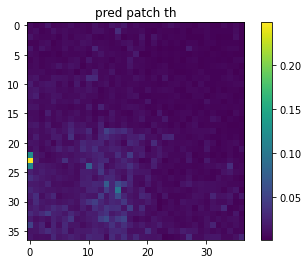

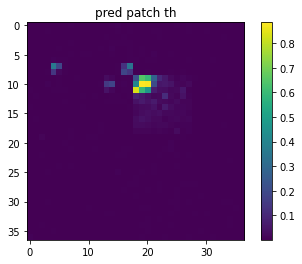

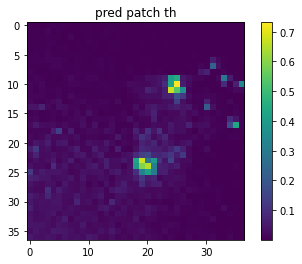

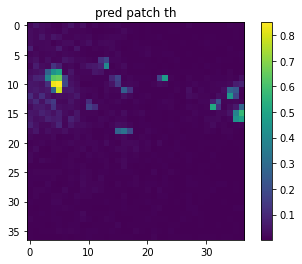

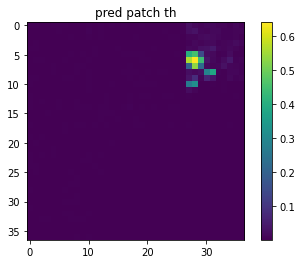

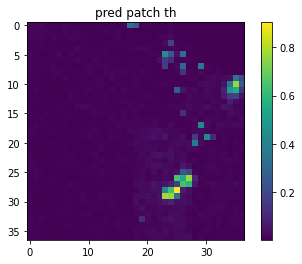

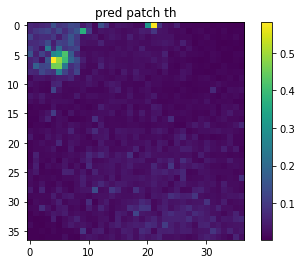

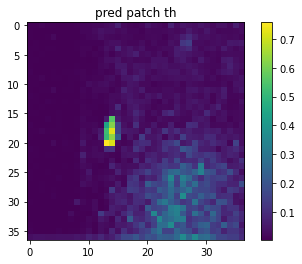

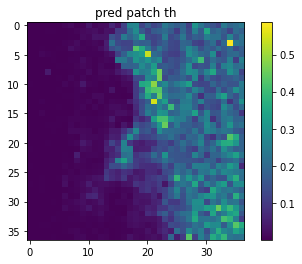

In [140]:
print(results[0].shape)
for result in results[:]:
    result = skimage.measure.block_reduce(result, (7,7,3), np.max)
    # result[0,0,0] = 1
    # result[1,0,0] = 0
    print(result.shape)
    plt.figure()
    plt.imshow(result, interpolation='none')
    plt.title("pred patch th")
    plt.colorbar()

In [141]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt
def cvBBOX(path=''):
    # Grayscale then Otsu's threshold
    image = cv2.imread(path)
    # image = (results[0]*255).astype("uint8")   # for numpy float array
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

    # cv2.imshow('thresh', thresh)
    # cv2.imshow('image', image)
    # cv2.waitKey()

    plt.imshow( thresh/255)
    plt.colorbar()
    plt.show()
    plt.imshow( image[:,:,::-1])
    plt.show()

# cvBBOX('datasets/bad/5_jpg.rf.efd13187101f89b1879fde68a8cd51d9.jpg')
# cvBBOX('datasets/bad/5_jpg.rf.efd13187101f89b1879fde68a8cd51d9.jpg')

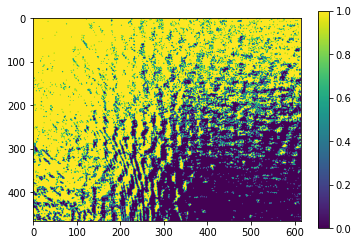

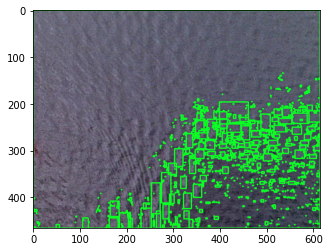

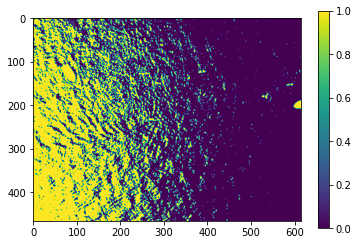

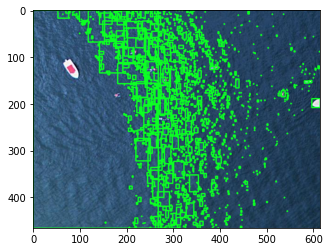

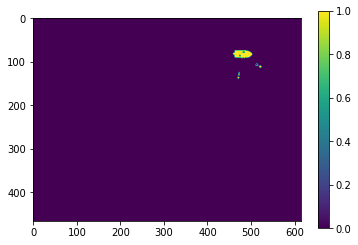

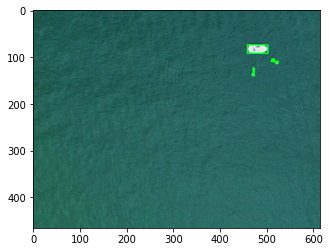

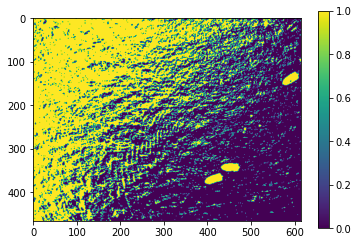

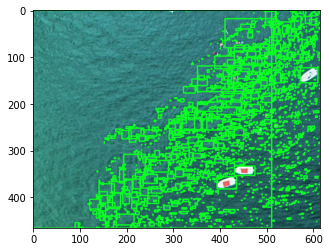

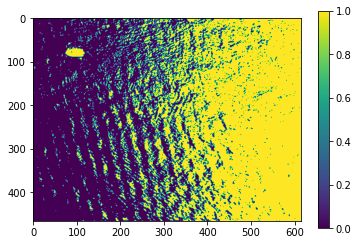

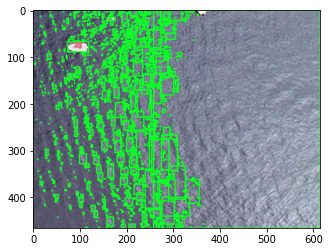

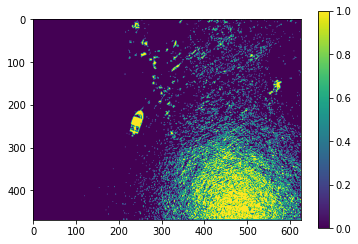

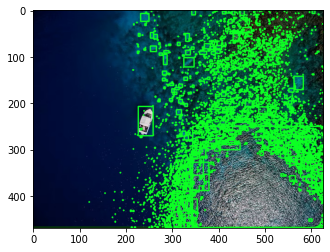

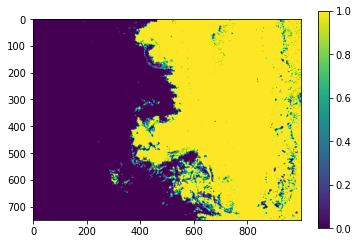

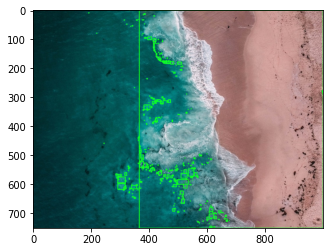

In [142]:
image_list =[]
image_list.append("datasets/mixed/53_jpg.rf.4976870a5e5af15e47206832ade51ed6.jpg")

image_list.append("datasets/bad/5_jpg.rf.efd13187101f89b1879fde68a8cd51d9.jpg")
image_list.append("datasets/bad/12_jpg.rf.3e89e71970211bfc29395fc2a8524c99.jpg")
image_list.append("datasets/mixed/47_jpg.rf.e9ddd312d9bce1895776d1c2a1c19f94.jpg")
image_list.append("datasets/bad/8_jpg.rf.b9f95418c204e14db64bc06bcf057d94.jpg")
image_list.append("aerial-shot-boat-beautiful-blue-ocean-bonaire-caribbean_181624-6680.jpg")
image_list.append("aerial-shot-shoreline.jpg")

for path in image_list:
    cvBBOX(path=path)